In [1]:
import numpy as np
import pandas as pd
from os.path import join
from scipy.spatial.transform import Rotation as R 
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
!ls ../dataset/

04_04_2019_21_17_23	    09_04_2019_17_14_24		trunck
08_05_2019_18_18_14	    12_04_2019_12_18_35
08_05_2019_18_18_14.tar.gz  12_04_2019_12_18_35.tar.gz


In [12]:


class DataAnalysor:
    def __init__(self, dir_name):
        self.dir_name = join("../dataset", dir_name)
    
    def readGroundTruth(self):
        gt_path = join(self.dir_name, "dataset/ground_truth/result.csv")
        self.df_gt_in_base = pd.read_csv(gt_path,header=None,names=["x","y","z"])
        
    def readProcessedData(self):
        hough_path = join(self.dir_name, "dataset/processed/result_method_hough.csv")
        self.df_hough = pd.read_csv(hough_path)
        
        #combile_path = join(self.dir_name, "dataset/processed/result_method_combile.csv")
        #self.df_combile = pd.read_csv(combile_path)
        
        #morphology_path = join(self.dir_name, "dataset/processed/result_method_morphology.csv")
        #self.df_morphology = pd.read_csv(morphology_path)
        
        #hough_particle_filter_path = join(self.dir_name, "dataset/processed/result_hough_particle_filter.csv")
        #self.df_hough_particle_filter = pd.read_csv(hough_particle_filter_path)

    def computeErrorInBase(self, df_processed_result):
        df = df_processed_result.copy()
        df["0_error_x"] = (df_processed_result["corners_in_base_0_x"] - self.df_gt_in_base["x"][0]).abs()
        df["1_error_x"] = (df_processed_result["corners_in_base_1_x"] - self.df_gt_in_base["x"][1]).abs()
        df["2_error_x"] = (df_processed_result["corners_in_base_2_x"] - self.df_gt_in_base["x"][2]).abs()
        df["3_error_x"] = (df_processed_result["corners_in_base_3_x"] - self.df_gt_in_base["x"][3]).abs()
        df["0_error_y"] = (df_processed_result["corners_in_base_0_y"] - self.df_gt_in_base["y"][0]).abs()
        df["1_error_y"] = (df_processed_result["corners_in_base_1_y"] - self.df_gt_in_base["y"][1]).abs()
        df["2_error_y"] = (df_processed_result["corners_in_base_2_y"] - self.df_gt_in_base["y"][2]).abs()
        df["3_error_y"] = (df_processed_result["corners_in_base_3_y"] - self.df_gt_in_base["y"][3]).abs()
        df["0_error_z"] = (df_processed_result["corners_in_base_0_z"] - self.df_gt_in_base["z"][0]).abs()
        df["1_error_z"] = (df_processed_result["corners_in_base_1_z"] - self.df_gt_in_base["z"][1]).abs()
        df["2_error_z"] = (df_processed_result["corners_in_base_2_z"] - self.df_gt_in_base["z"][2]).abs()
        df["3_error_z"] = (df_processed_result["corners_in_base_3_z"] - self.df_gt_in_base["z"][3]).abs()
        
        
        self.gt_xyzabc_in_base = np.zeros([6,1])
        self.gt_xyzabc_in_base[0,0] = df_processed_result["gt_xyz_abc_in_base_x"][0]
        self.gt_xyzabc_in_base[1,0] = df_processed_result["gt_xyz_abc_in_base_y"][0]
        self.gt_xyzabc_in_base[2,0] = df_processed_result["gt_xyz_abc_in_base_z"][0]
        self.gt_xyzabc_in_base[3,0] = df_processed_result["gt_xyz_abc_in_base_a"][0]
        self.gt_xyzabc_in_base[4,0] = df_processed_result["gt_xyz_abc_in_base_b"][0]
        self.gt_xyzabc_in_base[5,0] = df_processed_result["gt_xyz_abc_in_base_c"][0]
        # compute xyz_abc in base
        df["error_angle_x"] = 0.0
        df["error_angle_y"] = 0.0
        df["error_angle_z"] = 0.0

        df["error_x_avg"] = 0.0
        df["error_y_avg"] = 0.0
        df["error_z_avg"] = 0.0
        df["not_mismatch"] = True
        
        df["left_corners_x_avg"] = (df["left_corners_in_pixel_0_x"] + df["left_corners_in_pixel_1_x"] \
                             +df["left_corners_in_pixel_2_x"] + df["left_corners_in_pixel_3_x"]) / 4.0
        df["left_corners_y_avg"] = (df["left_corners_in_pixel_0_y"] + df["left_corners_in_pixel_1_y"] \
                             +df["left_corners_in_pixel_2_y"] + df["left_corners_in_pixel_3_y"]) / 4.0
        
        for index, row in df_processed_result.iterrows():
            if row["success"] == False:
                continue
            
            #df["error_angle_x"][index] = euler_angle_distance(xyzabc_in_base[3:6,0], self.gt_xyzabc_in_base[3:6,0])
            
            error_angle = euler_angle_distance([row["xyz_abc_in_base_a"], row["xyz_abc_in_base_b"], row["xyz_abc_in_base_c"]], 
                                               [row["gt_xyz_abc_in_base_a"], row["gt_xyz_abc_in_base_b"], row["gt_xyz_abc_in_base_c"]])
            df.loc[index, "error_angle_x"] = error_angle[0]
            df.loc[index, "error_angle_y"] = error_angle[1]
            df.loc[index, "error_angle_z"] = error_angle[2]

            #print("error_angle", error_angle)
            error_x = row["xyz_abc_in_base_x"] - row["gt_xyz_abc_in_base_x"]
            error_y = row["xyz_abc_in_base_y"] - row["gt_xyz_abc_in_base_y"]
            error_z = row["xyz_abc_in_base_z"] - row["gt_xyz_abc_in_base_z"]
            df.loc[index, "error_x_avg"] = error_x
            df.loc[index, "error_y_avg"] = error_y
            df.loc[index, "error_z_avg"] = error_z
            
            xyz_threshold = 5
            abc_threshold = 0.2
            if error_x > xyz_threshold or error_y>xyz_threshold or error_z>xyz_threshold or \
                 error_angle[0] > abc_threshold or error_angle[1] > abc_threshold or error_angle[2] > abc_threshold:
                df.loc[index, "not_mismatch"] = False
            
        return df
        
        
        
        


In [13]:
def getRotationMatrix(abc):
    r = R.from_euler('XYZ',abc, degrees=False)
    return r.as_dcm()
def angle_distance(abc_1, abc_2):
    vec1=[0,0,1]
    vec2=[0,0,1]
    vec1 = np.dot(getRotationMatrix(abc_1), vec1)
    vec2 = np.dot(getRotationMatrix(abc_2), vec2)
    print(vec1, vec2)
    cos_angle = np.dot(vec1,vec2)/(np.linalg.norm(vec1)*np.linalg.norm(vec2))
    if abs(cos_angle - 1.0) < 1e-5:
        return 0
    angle=np.arccos(cos_angle)
    return angle

In [14]:
def euler_angle_distance_method1(abc_1, abc_2): 
    # see http://www.cs.cmu.edu/~cga/dynopt/readings/Rmetric.pdf 
    def d(angle0, angle1):
        return min(abs(angle0-angle1), 2*np.pi - abs(angle0-angle1))
    distance = np.sqrt(d(abc_1[0], abc_2[0])**2 + d(abc_1[1], abc_2[1])**2 + d(abc_1[2], abc_2[2])**2)
    return distance
    
def euler_angle_distance(abc_1, abc_2): 
    # roll is too close to pi/2, lets add a rotation -pi/2 to them
    r1 = R.from_euler('XYZ', abc_1, degrees=False)
    r2 = R.from_euler('XYZ', abc_2, degrees=False)
    
    # -pi
    pitch_compensate = R.from_euler('Z', -np.pi/2.0, degrees=False)
    yaw_compensate = R.from_euler('Y', -np.pi/2.0, degrees=False)
    
    r1 = pitch_compensate*yaw_compensate* r1 
    r2 = pitch_compensate*yaw_compensate* r2

    #r1 = r2.inv() * r1 
    xyz_error = r1.as_euler('XYZ', degrees=False) - r2.as_euler('XYZ', degrees=False)
    #print(r1.as_euler('XYZ', degrees=False), r2.as_euler('XYZ', degrees=False))
    return xyz_error
gt_abc_in_base = [1.598960, 1.633200, -0.010637]
abc = [2.17049, 1.6243299999999998, -0.582609]
r1 = R.from_euler('XYZ', gt_abc_in_base, degrees=False)
print(r1.as_quat())

r2 = R.from_euler('XYZ', abc, degrees=False)
print(r2.as_quat())
pitch_compensate = R.from_euler('Z', -np.pi/2.0, degrees=False)
yaw_compensate = R.from_euler('Y', -np.pi/2.0, degrees=False)
    
r1 = pitch_compensate*yaw_compensate* r1 
r2 = pitch_compensate*yaw_compensate* r2

print(r1.as_euler('XYZ', degrees=False))
print(r2.as_euler('XYZ', degrees=False))

[0.48821887 0.51065082 0.52001497 0.48006511]
[0.4855034  0.49918607 0.52264109 0.49188007]
[-0.00175957  0.06237889  0.01758157]
[-0.03023353  0.04418578  0.01775278]


In [15]:
data_analysor = DataAnalysor("08_05_2019_18_18_14")
data_analysor.readGroundTruth()
data_analysor.readProcessedData()
print(data_analysor.df_gt_in_base.columns)
#print(data_analysor.df_morphology.columns)


Index(['x', 'y', 'z'], dtype='object')


In [16]:
data = data_analysor.df_hough.loc[1,["xyz_abc_in_base_a", "xyz_abc_in_base_b", "xyz_abc_in_base_c", "gt_xyz_abc_in_base_a", "gt_xyz_abc_in_base_b", "gt_xyz_abc_in_base_c"]]
euler_angle = [data["xyz_abc_in_base_a"], data["xyz_abc_in_base_b"], data["xyz_abc_in_base_c"]]
gt_euler_angle = [data["gt_xyz_abc_in_base_a"], data["gt_xyz_abc_in_base_b"], data["gt_xyz_abc_in_base_c"]]
print(euler_angle, gt_euler_angle)
euler_angle_distance(euler_angle, gt_euler_angle)

[2.0343299999999997, 2.33938, 2.58184] [1.36093, 1.6549200000000002, 0.23643499999999998]


array([-0.42562201,  0.58872394, -3.11961766])

In [17]:
def visualizeCorners(df):
    """
    visualize corners, in order to make sure the abc are correct
    """
    # Set up the plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    
    corner = np.array([[50,50,0], [-50,50,0],[-50,-50,0],[50,-50,0]])
    color = ["r","g","b","y"]
    print(corner.shape[0])
    for i in range(corner.shape[0]):
        rotated_corner = []
        for index, row in df.iterrows():
            angle_a = row["xyz_abc_in_base_a"]
            angle_b = row["xyz_abc_in_base_b"]
            angle_c = row["xyz_abc_in_base_c"]
            print("angle_c", angle_c)
            r = R.from_euler("xyz", [angle_a, angle_b, angle_c], degrees=False)
            #r = R.from_euler("xyz", [0, 0, 0], degrees=False)
            
            new_corner = np.dot(r.as_dcm(), corner[i,:])
            print(new_corner)
            if(index>10):
                break
            rotated_corner.append(new_corner)
        rotated_corner = np.array(rotated_corner)
        print(rotated_corner)
        scatter=ax.scatter(rotated_corner[:,0], rotated_corner[:,1], rotated_corner[:,2], c=color[i])
    fig.show()
    

In [18]:
#visualizeCorners(data_analysor.df_hough)

In [19]:

def visualizeErrorHeatMapInBase(success_mask, x, y, z, error, title, filter_fault=False, treshold=100):
    filterd_index = []
    for i in range(len(success_mask)):
        if(success_mask[i] == 1):
            if(not filter_fault):
                filterd_index.append(i)
            elif (filter_fault and error[i] < treshold):
                filterd_index.append(i)
            
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    scatter=ax.scatter(x[filterd_index], y[filterd_index], z[filterd_index], c=error[filterd_index])
    plt.colorbar(scatter, ax=ax)
    fig.show()
def visualizeErrorDistribution(success_mask, error, error_name, filter_fault=False, treshold=30):
    filterd_index = []
    for i in range(len(success_mask)):
        if(success_mask[i] == 1):
            if(not filter_fault):
                filterd_index.append(i)
            elif (filter_fault and error[i] < treshold):
                filterd_index.append(i)
                
    # Set up the plot
    fig = plt.figure()
    
    ax = fig.add_subplot(311)
    
    # Draw the plot
    ax.hist(error[filterd_index], bins = 20,
             color = 'blue', edgecolor = 'black')
    
    # Title and labels
    ax.set_title(error_name + " distribution")
    ax.set_xlabel(error_name)
    ax.set_ylabel("number")
def visualizeSuccessHeatMapInBase(success_mask, x, y, z, error, title, filter_fault=False, treshold=30):
    filterd_index = []
    for i in range(len(success_mask)):
        if(not filter_fault):
            filterd_index.append(i)
        elif (filter_fault and error[i] < treshold):
            filterd_index.append(i)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    scatter=ax.scatter(x[filterd_index], y[filterd_index], z[filterd_index], c=success_mask[filterd_index])
    plt.colorbar(scatter, ax=ax)
    fig.show()
def visualize(df, method):
    %matplotlib notebook
    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_x_avg"], method + ": error of x")

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_x_avg"], method + ": error of x", True)

    visualizeSuccessHeatMapInBase(df["not_mismatch"],df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_x_avg"], method + ": sucess", True)
    print("success ratio: ", np.sum(df["success"])/df["success"].shape[0])
    print("mismatch ratio: ",1.0- np.sum(df["not_mismatch"])/df["not_mismatch"].shape[0])

    visualizeErrorDistribution(df["not_mismatch"], df["error_x_avg"], "Hough: error of x (mm)")
    visualizeErrorDistribution(df["not_mismatch"], df["error_x_avg"], "Hough: zoomed error of x (mm)", True)

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_y_avg"], method + ": error of y")

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_y_avg"], method + ": error of y", True)

    visualizeErrorDistribution(df["not_mismatch"], df["error_y_avg"], "Hough: error of y (mm)")
    visualizeErrorDistribution(df["not_mismatch"], df["error_y_avg"], "Hough: zoomed error of y (mm)", True)
    
    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_z_avg"], method + ": error of z")

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_z_avg"], method + ": error of z", True)

    visualizeErrorDistribution(df["not_mismatch"], df["error_z_avg"], method+": error of z (mm)")
    visualizeErrorDistribution(df["not_mismatch"], df["error_z_avg"], method+": zoomed error of z (mm)", True)

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_x"]/ np.pi * 180, method + ": error of a(deg)")

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_x"]/ np.pi * 180, method+": error of a(deg)", True)

    visualizeErrorDistribution(df["not_mismatch"], df["error_angle_x"] / np.pi * 180, method+": error of a (deg)")
    visualizeErrorDistribution(df["not_mismatch"], df["error_angle_x"] / np.pi * 180, method+": zoomed error of a (deg)", True)

    
    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_y"]/ np.pi * 180, method+": error of b(deg)")

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_y"]/ np.pi * 180, method+": error of b(deg)", True)

    visualizeErrorDistribution(df["not_mismatch"], df["error_angle_y"] / np.pi * 180, method+": error of b (deg)")
    visualizeErrorDistribution(df["not_mismatch"], df["error_angle_y"] / np.pi * 180, method+": zoomed error of b (deg)", True)

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_z"]/ np.pi * 180, method+": error of c(deg)")

    visualizeErrorHeatMapInBase(df["not_mismatch"], df["gt_xyz_abc_in_cam_x"], df["gt_xyz_abc_in_cam_y"], 
                                df["gt_xyz_abc_in_cam_z"], df["error_angle_z"]/ np.pi * 180, method+": error of c(deg)", True)

    visualizeErrorDistribution(df["not_mismatch"], df["error_angle_z"] / np.pi * 180, method+": error of c (deg)")
    visualizeErrorDistribution(df["not_mismatch"], df["error_angle_z"] / np.pi * 180, method+": zoomed error of c (deg)", True)
    

<IPython.core.display.Javascript object>


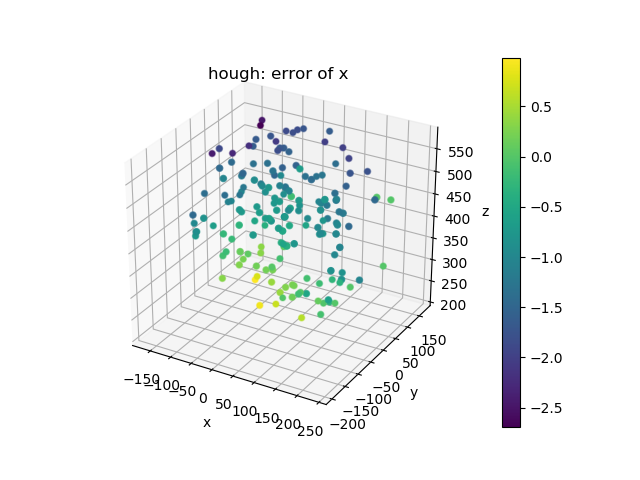

<IPython.core.display.Javascript object>


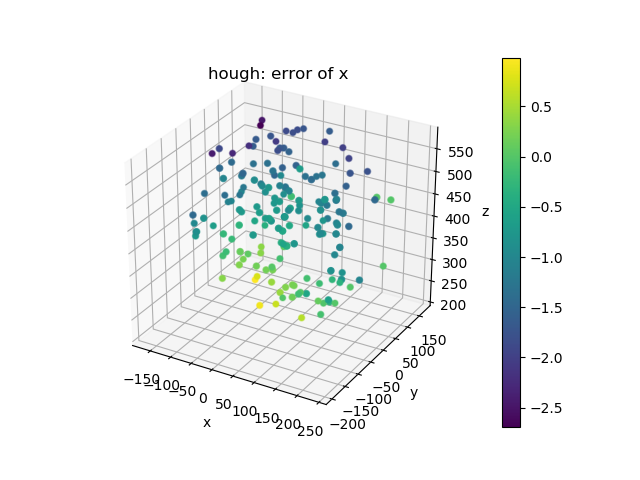

<IPython.core.display.Javascript object>


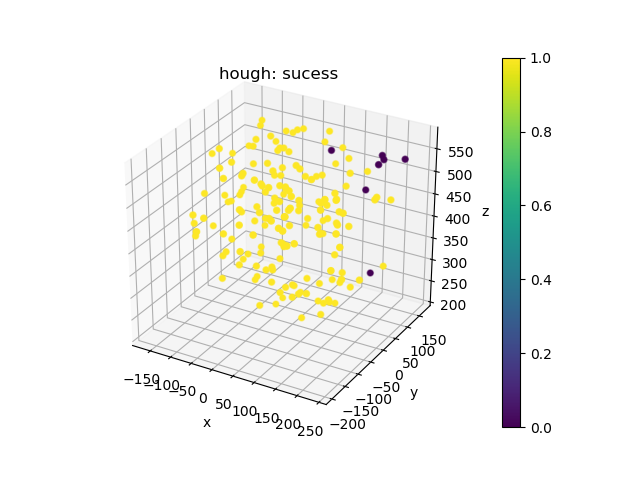

success ratio:  0.965
mismatch ratio:  0.14


<IPython.core.display.Javascript object>


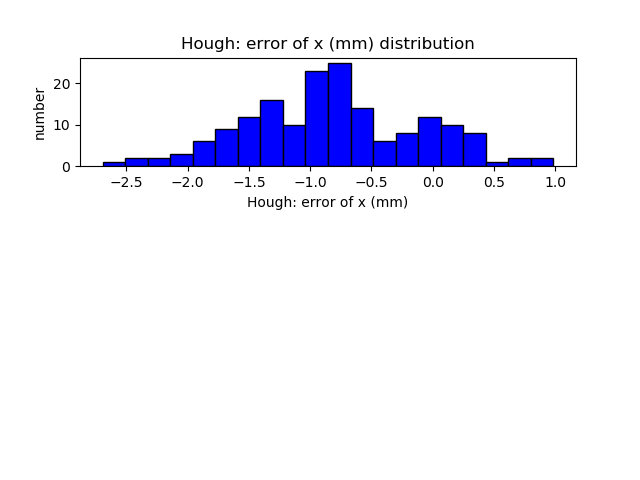

<IPython.core.display.Javascript object>


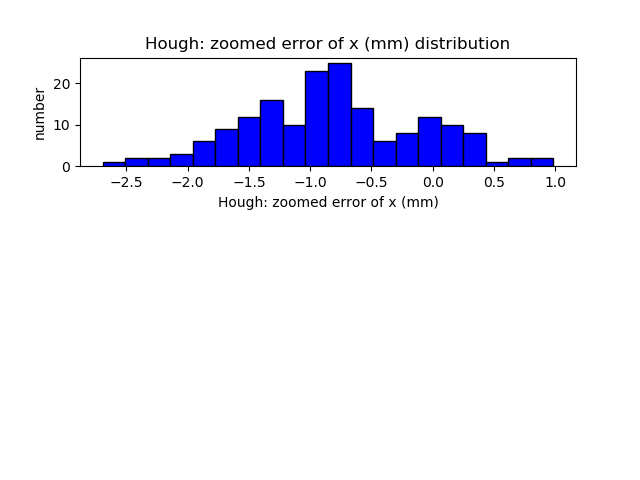

<IPython.core.display.Javascript object>


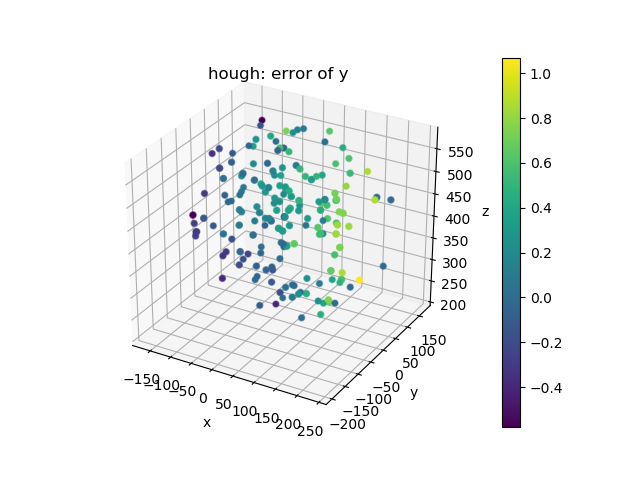

<IPython.core.display.Javascript object>


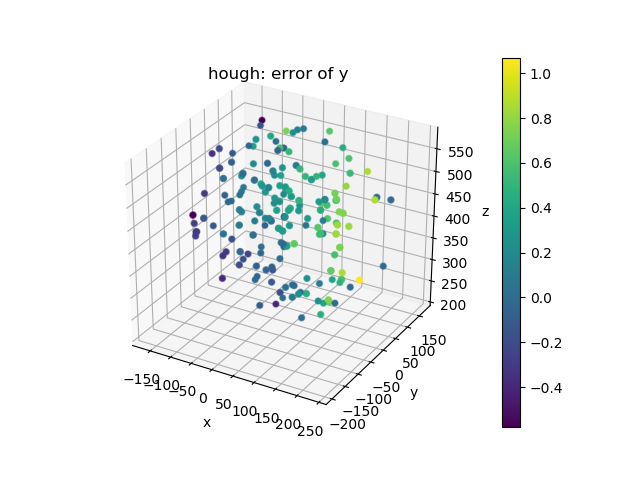

<IPython.core.display.Javascript object>


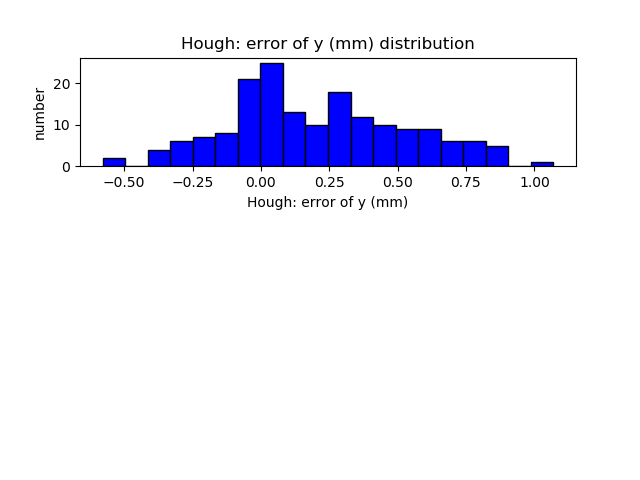

<IPython.core.display.Javascript object>


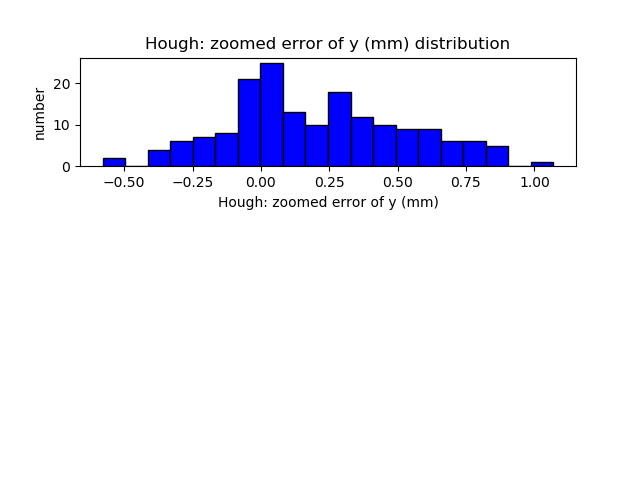

<IPython.core.display.Javascript object>


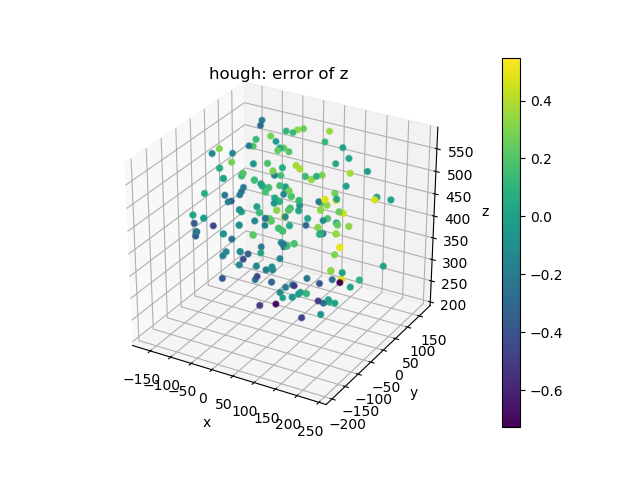

<IPython.core.display.Javascript object>


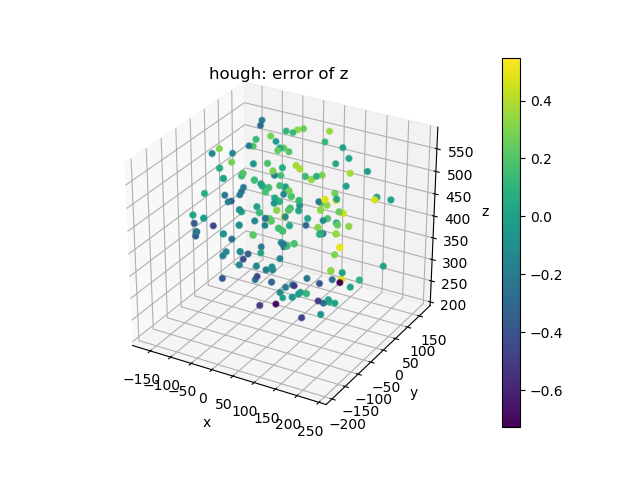

<IPython.core.display.Javascript object>


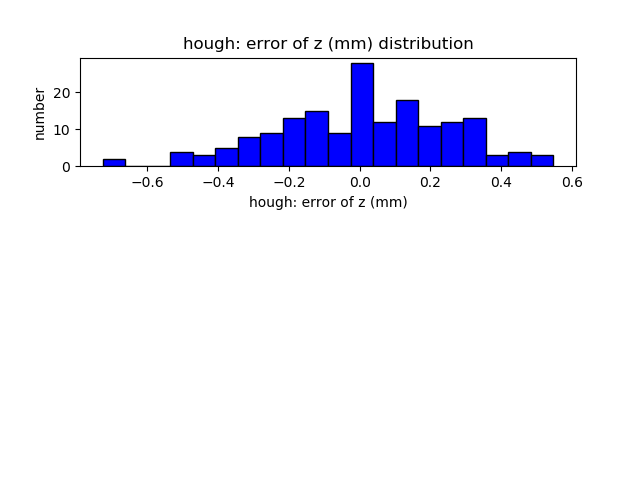

<IPython.core.display.Javascript object>


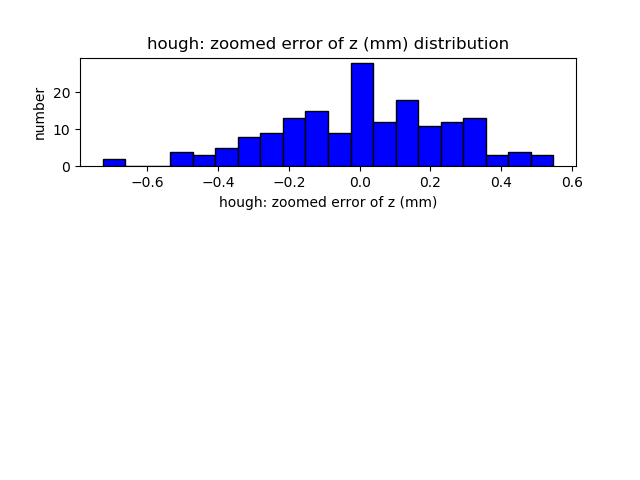

<IPython.core.display.Javascript object>


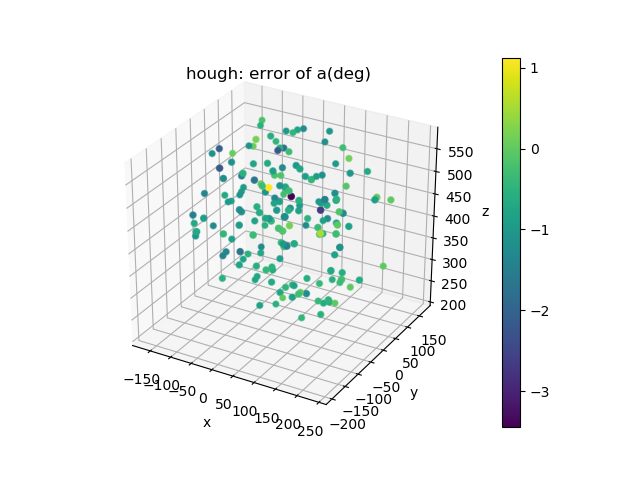

<IPython.core.display.Javascript object>


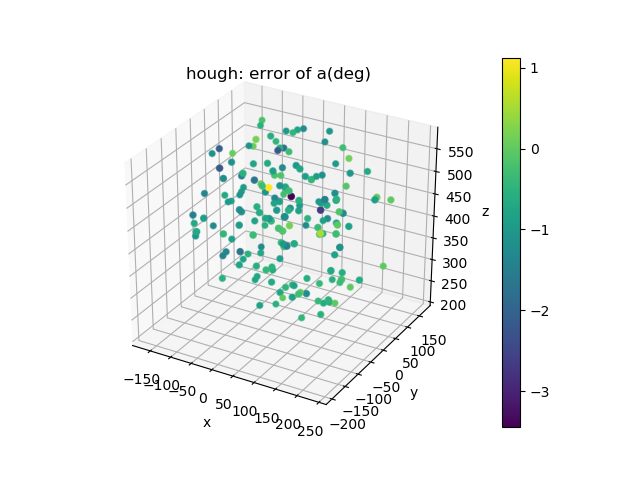

<IPython.core.display.Javascript object>


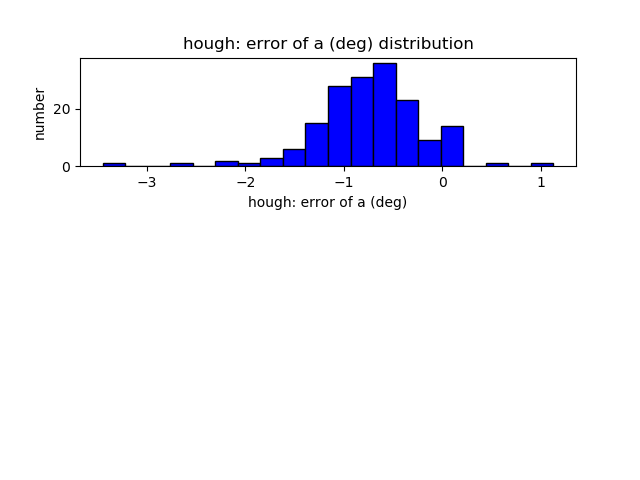

<IPython.core.display.Javascript object>


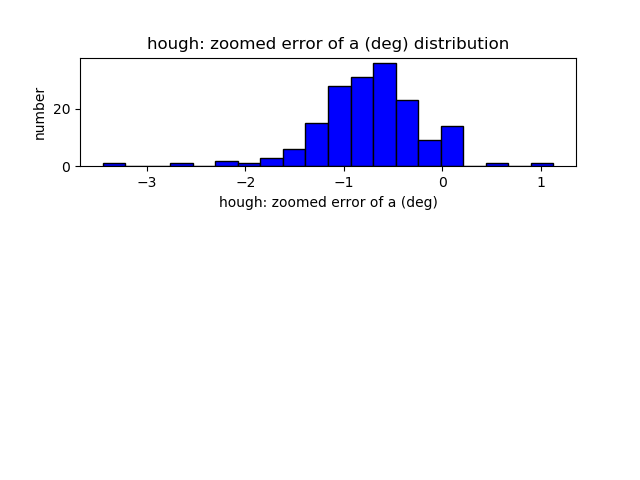

<IPython.core.display.Javascript object>


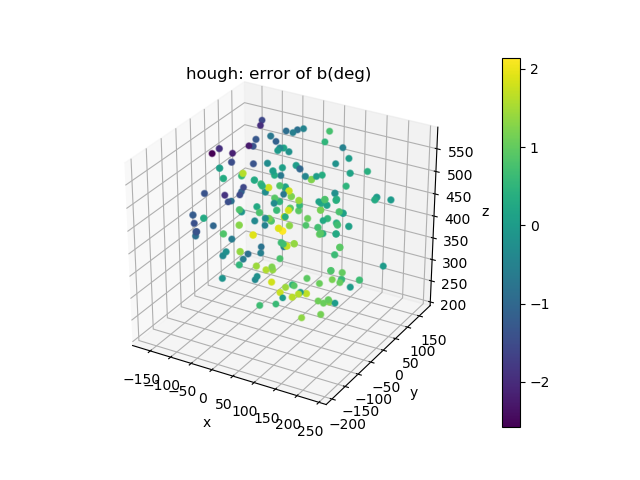

<IPython.core.display.Javascript object>


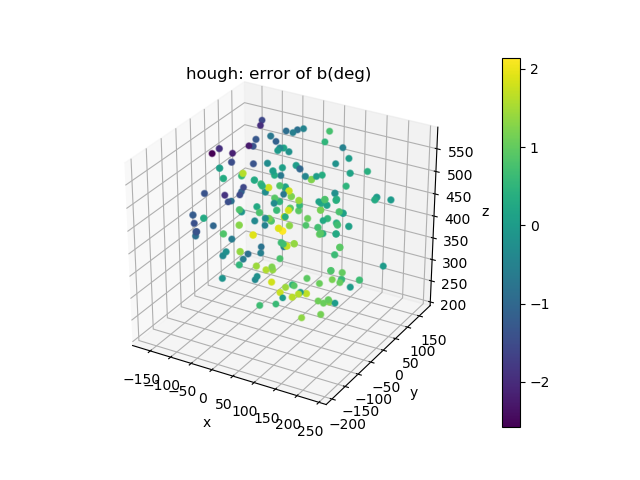

<IPython.core.display.Javascript object>


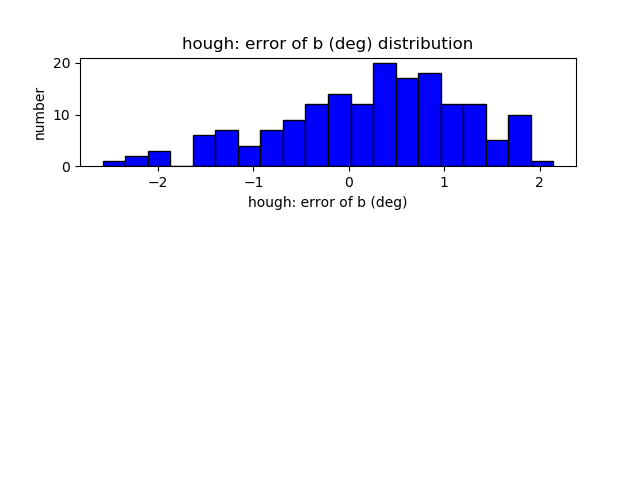

<IPython.core.display.Javascript object>


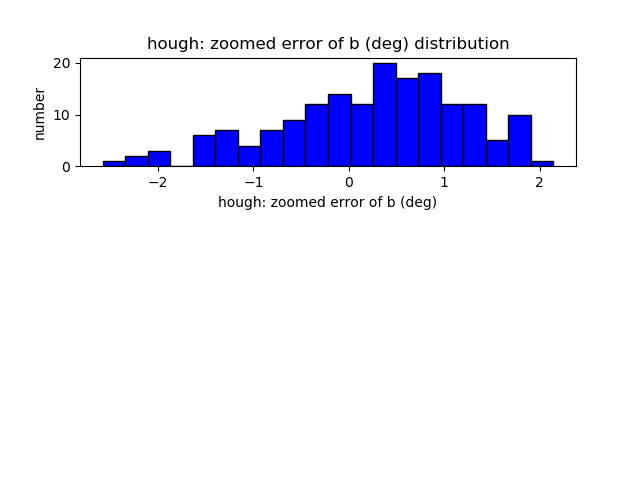

<IPython.core.display.Javascript object>


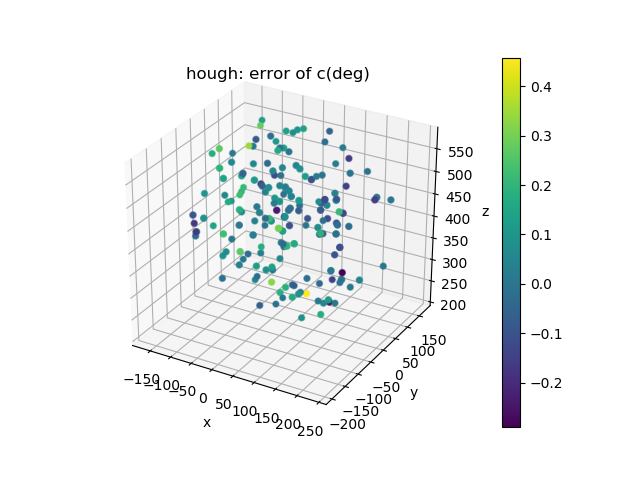

<IPython.core.display.Javascript object>


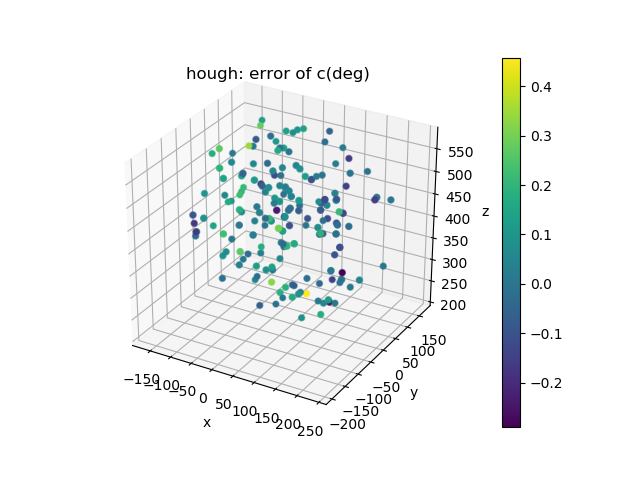

<IPython.core.display.Javascript object>


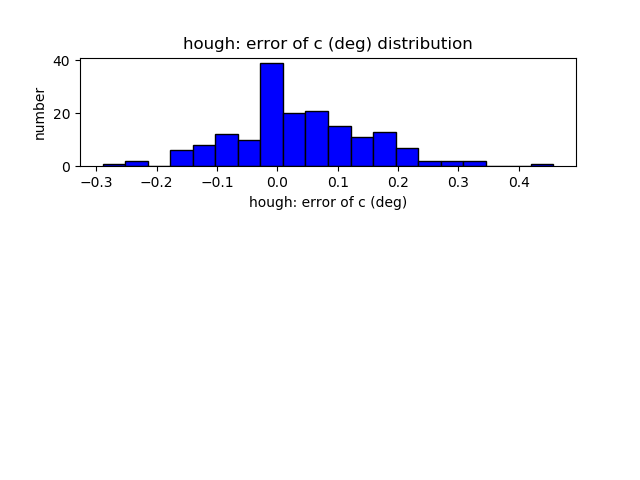

<IPython.core.display.Javascript object>


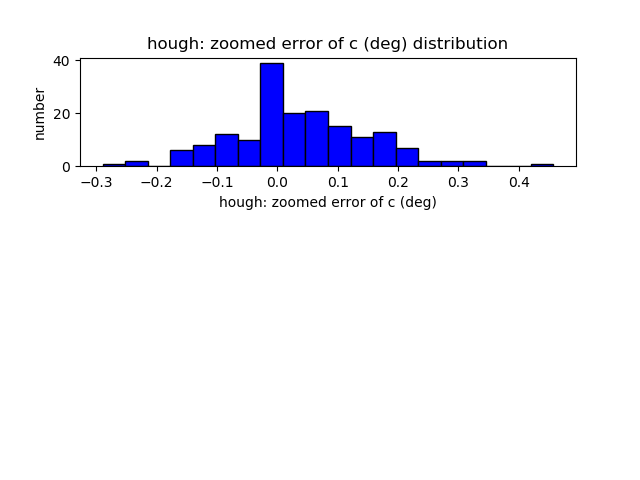

In [20]:
df_hough = data_analysor.computeErrorInBase(data_analysor.df_hough)
visualize(df_hough, "hough")



In [49]:
mask = df_hough["error_x_avg"] > 3.0
df_hough[mask]

Empty DataFrame
Columns: [id, success, left_corners_in_pixel_0_x, left_corners_in_pixel_0_y, left_corners_in_pixel_1_x, left_corners_in_pixel_1_y, left_corners_in_pixel_2_x, left_corners_in_pixel_2_y, left_corners_in_pixel_3_x, left_corners_in_pixel_3_y, right_corners_in_pixel_0_x, right_corners_in_pixel_0_y, right_corners_in_pixel_1_x, right_corners_in_pixel_1_y, right_corners_in_pixel_2_x, right_corners_in_pixel_2_y, right_corners_in_pixel_3_x, right_corners_in_pixel_3_y, corners_in_base_0_x, corners_in_base_0_y, corners_in_base_0_z, corners_in_base_1_x, corners_in_base_1_y, corners_in_base_1_z, corners_in_base_2_x, corners_in_base_2_y, corners_in_base_2_z, corners_in_base_3_x, corners_in_base_3_y, corners_in_base_3_z, xyz_abc_in_cam_x, xyz_abc_in_cam_y, xyz_abc_in_cam_z, xyz_abc_in_cam_a, xyz_abc_in_cam_b, xyz_abc_in_cam_c, xyz_abc_in_tool_x, xyz_abc_in_tool_y, xyz_abc_in_tool_z, xyz_abc_in_tool_a, xyz_abc_in_tool_b, xyz_abc_in_tool_c, xyz_abc_in_base_x, xyz_abc_in_base_y, xyz_abc_in_base_z, xyz_abc_in_base_a, xyz_abc_in_base_b, xyz_abc_in_base_c, gt_xyz_abc_in_base_x, gt_xyz_abc_in_base_y, gt_xyz_abc_in_base_z, gt_xyz_abc_in_base_a, gt_xyz_abc_in_base_b, gt_xyz_abc_in_base_c, gt_xyz_abc_in_cam_x, gt_xyz_abc_in_cam_y, gt_xyz_abc_in_cam_z, gt_xyz_abc_in_cam_a, gt_xyz_abc_in_cam_b, gt_xyz_abc_in_cam_c, 0_error_x, 1_error_x, 2_error_x, 3_error_x, 0_error_y, 1_error_y, 2_error_y, 3_error_y, 0_error_z, 1_error_z, 2_error_z, 3_error_z, error_angle_x, error_angle_y, error_angle_z, error_x_avg, error_y_avg, error_z_avg, left_corners_x_avg, left_corners_y_avg]
Index: []

[0 rows x 80 columns]

<IPython.core.display.Javascript object>


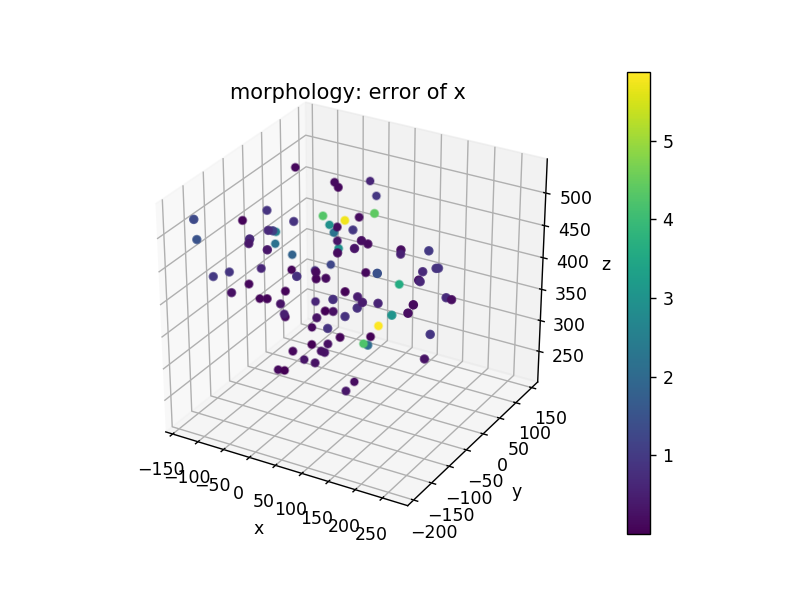

<IPython.core.display.Javascript object>


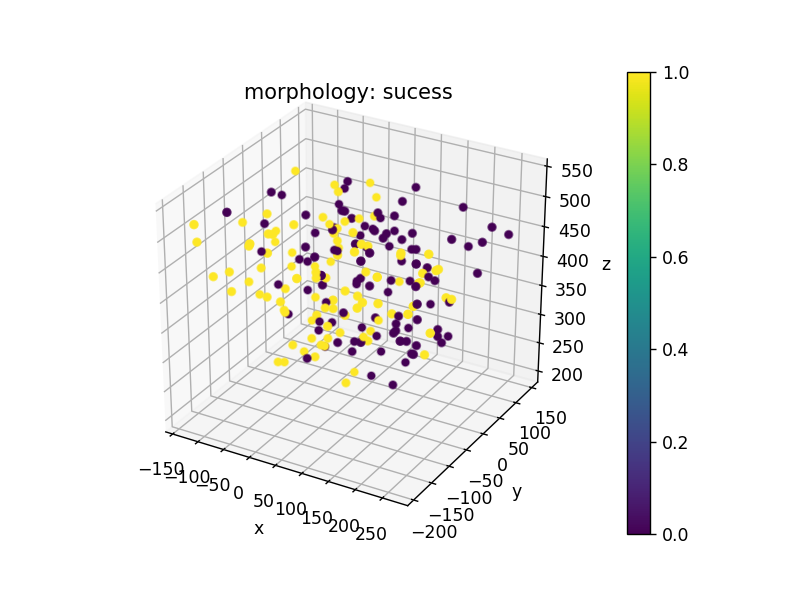

success ratio:  0.485


<IPython.core.display.Javascript object>


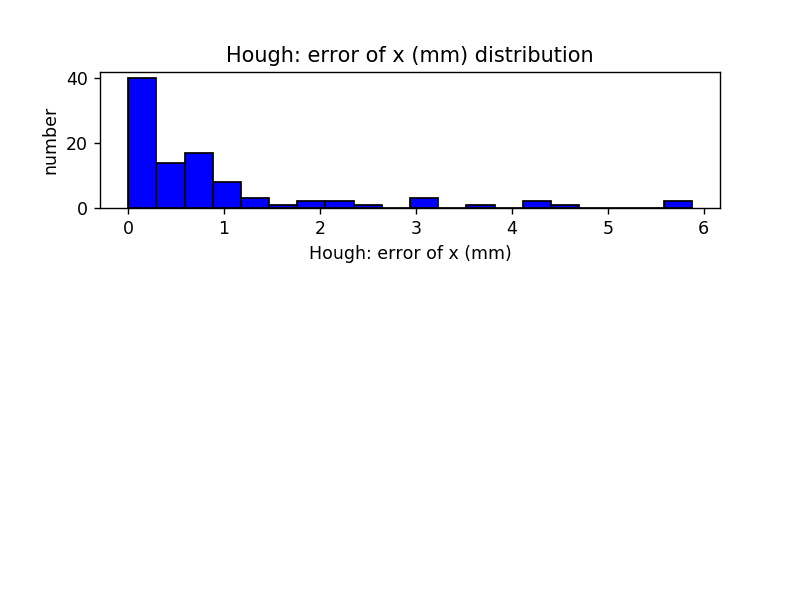

<IPython.core.display.Javascript object>


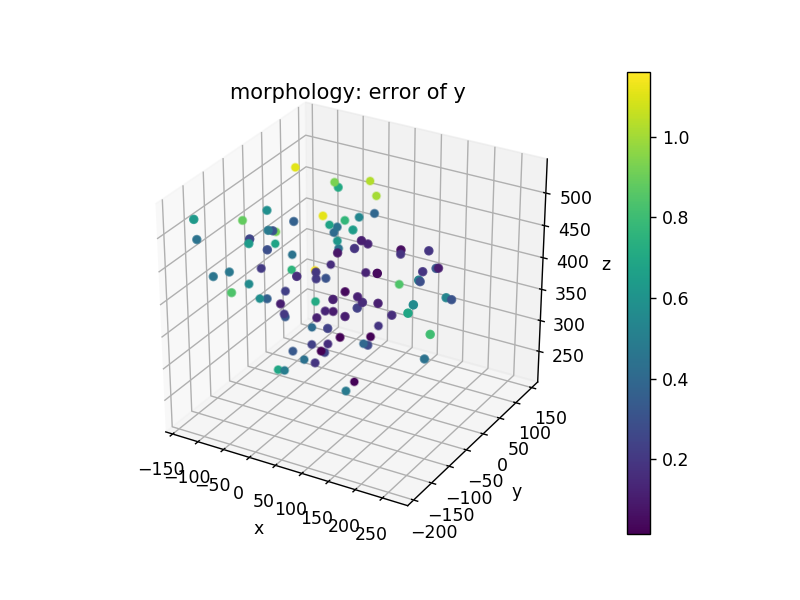

<IPython.core.display.Javascript object>


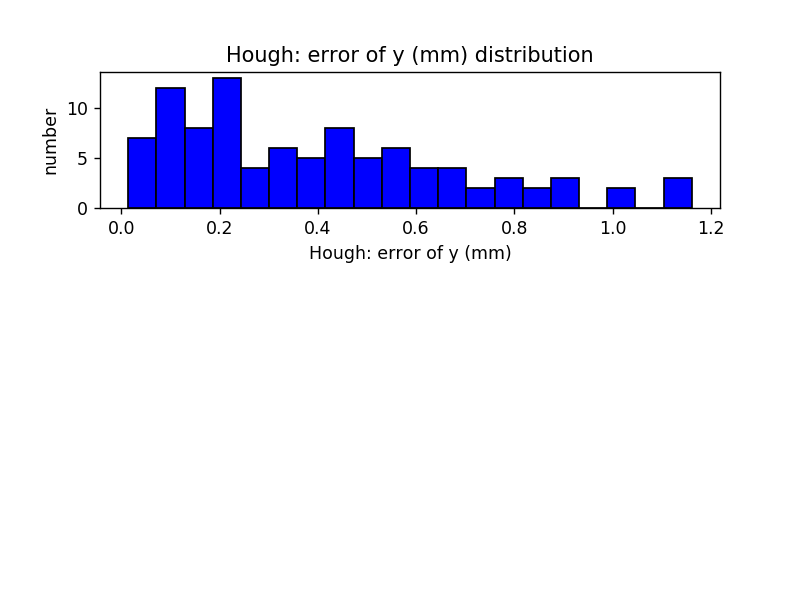

<IPython.core.display.Javascript object>


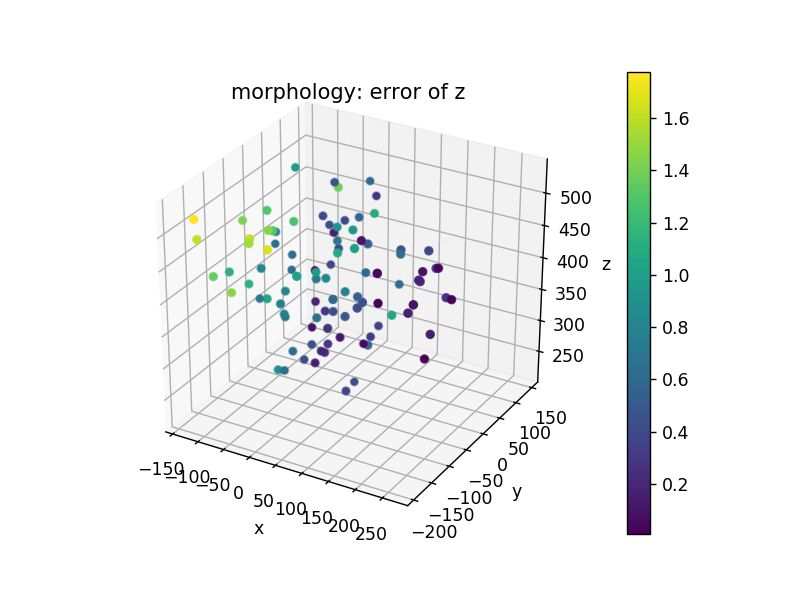

<IPython.core.display.Javascript object>


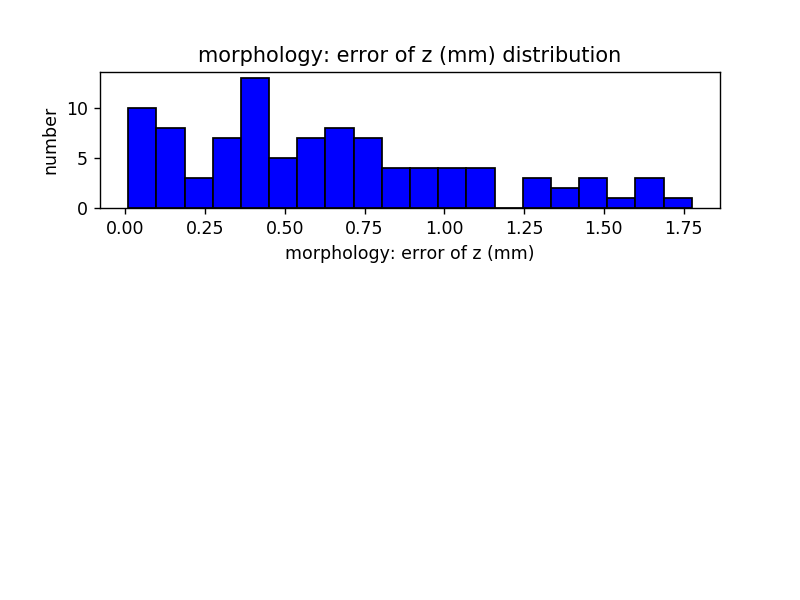

<IPython.core.display.Javascript object>


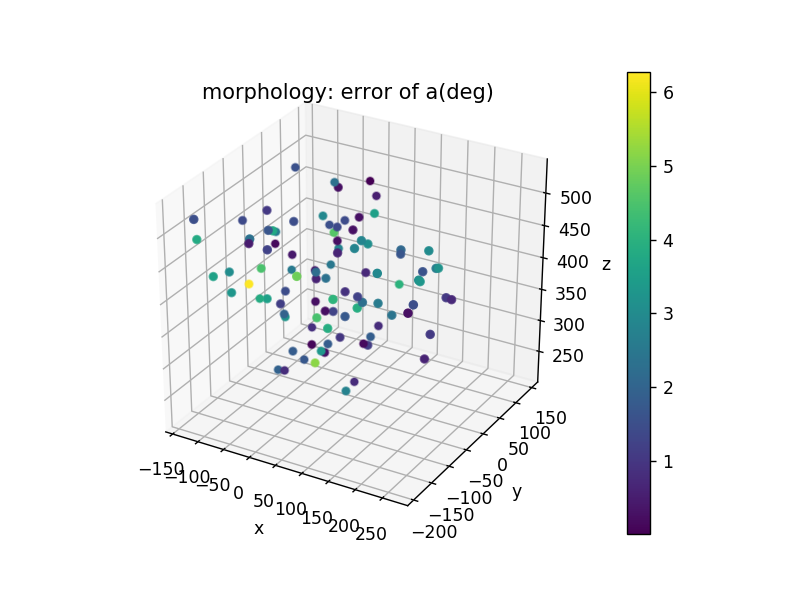

<IPython.core.display.Javascript object>


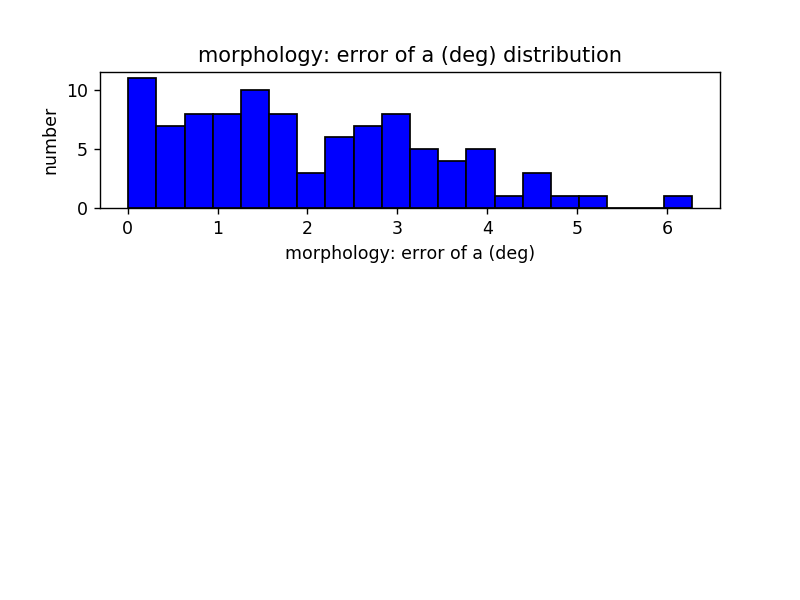

<IPython.core.display.Javascript object>


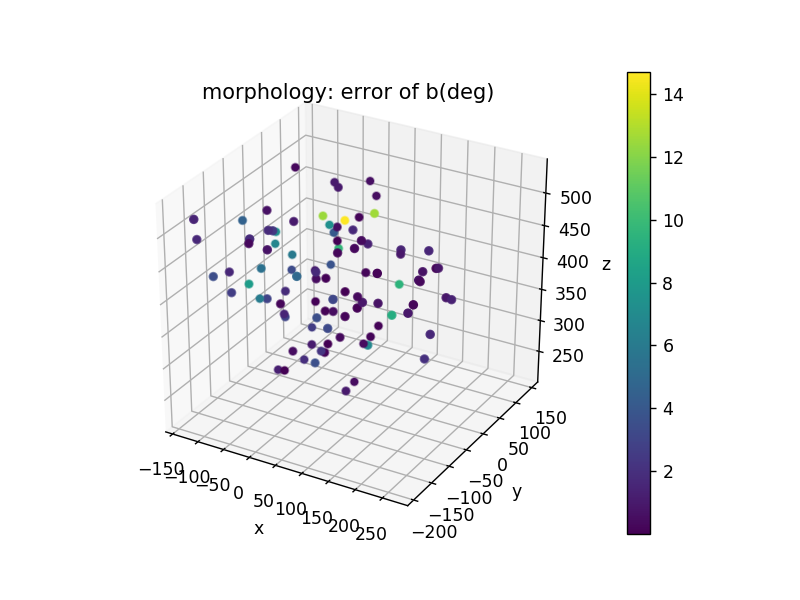

<IPython.core.display.Javascript object>


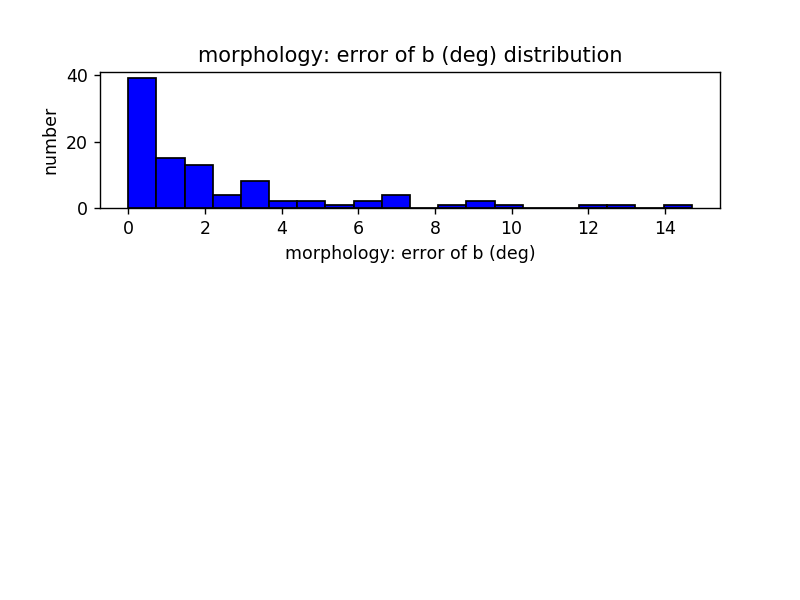

<IPython.core.display.Javascript object>


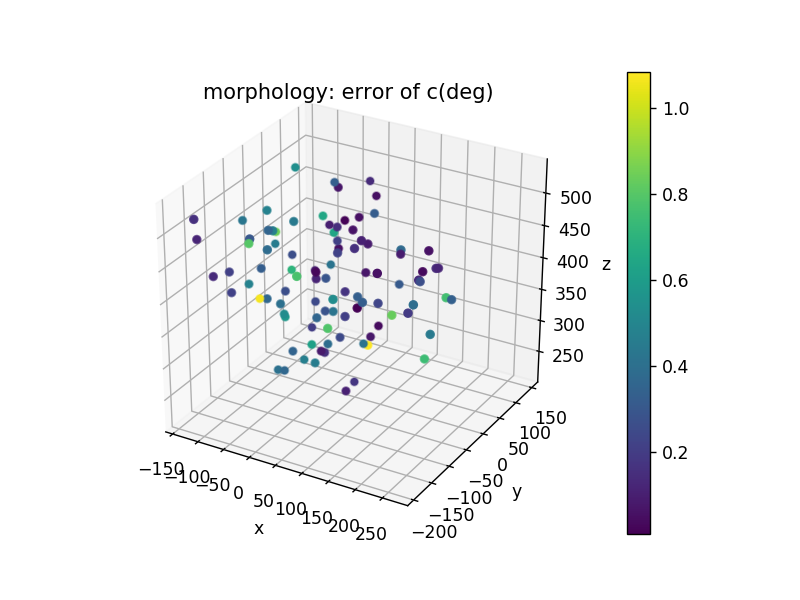

<IPython.core.display.Javascript object>


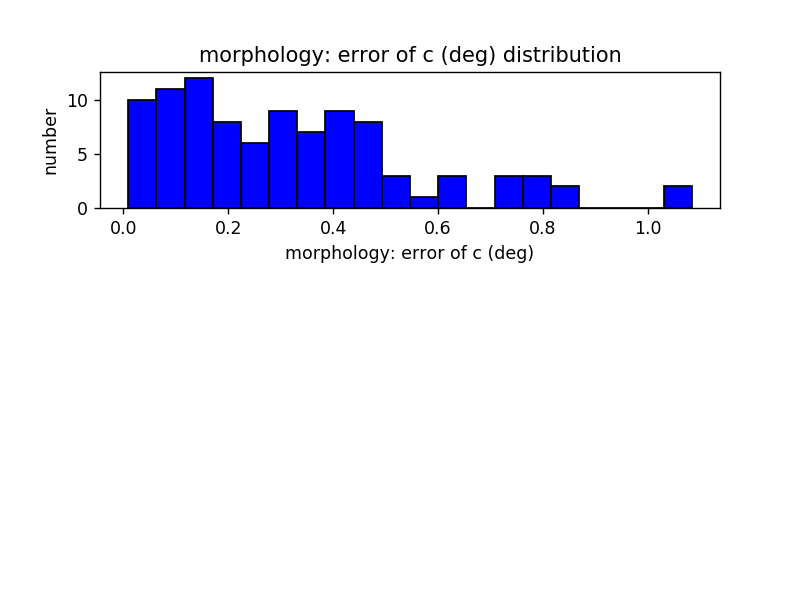

In [70]:

df_morphology = data_analysor.computeErrorInBase(data_analysor.df_morphology)
visualize(df_morphology, "morphology")

<IPython.core.display.Javascript object>


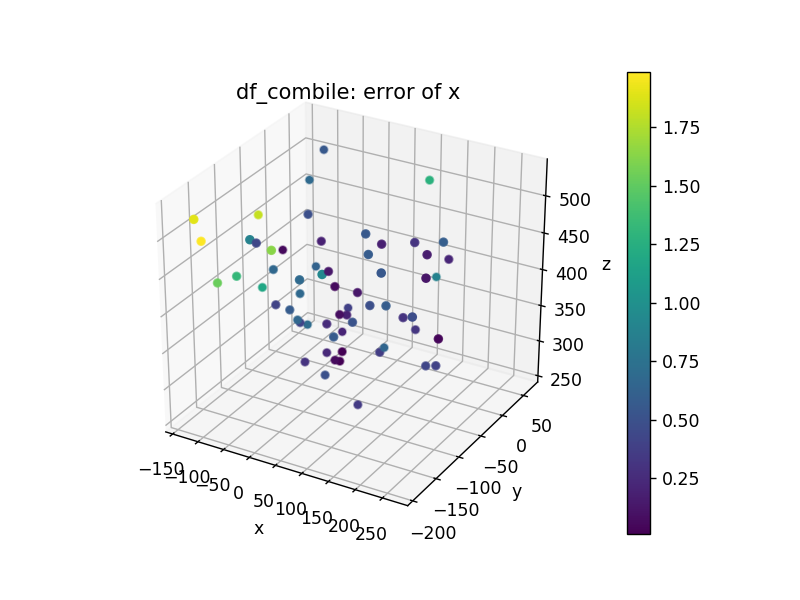

<IPython.core.display.Javascript object>


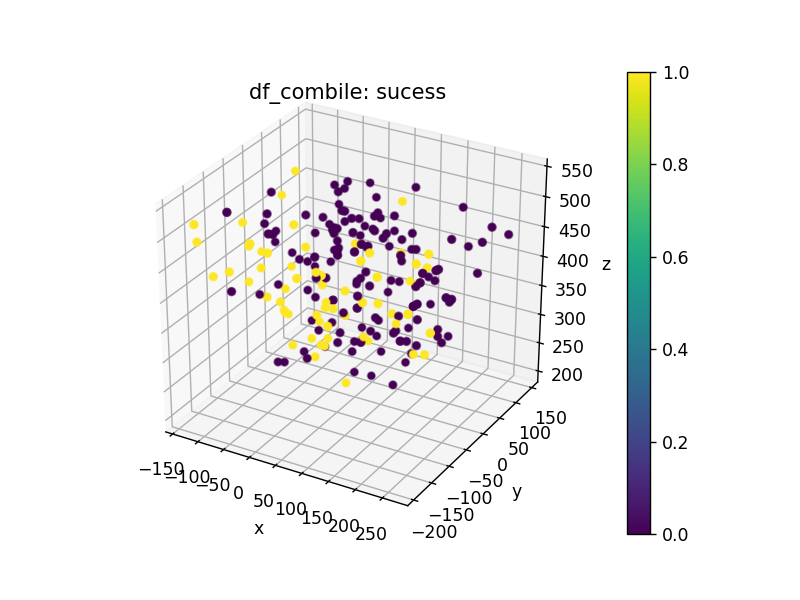

success ratio:  0.31


<IPython.core.display.Javascript object>


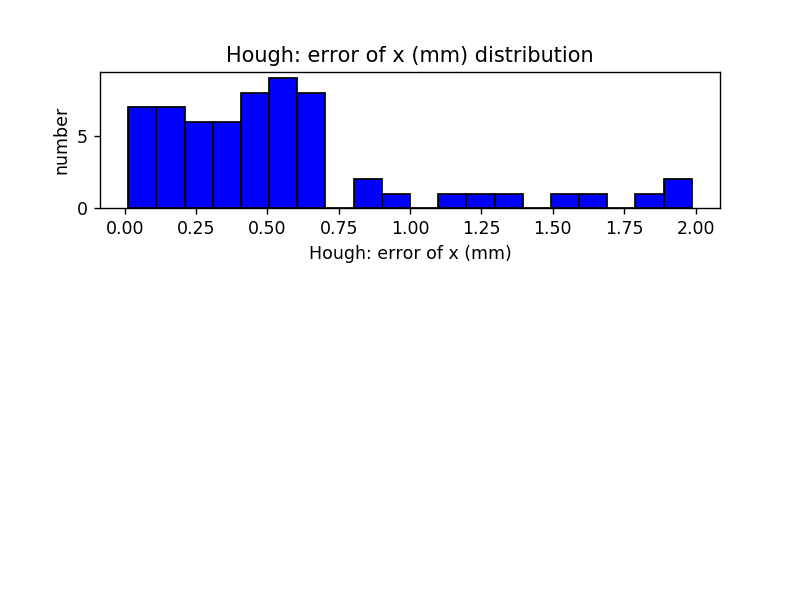

<IPython.core.display.Javascript object>


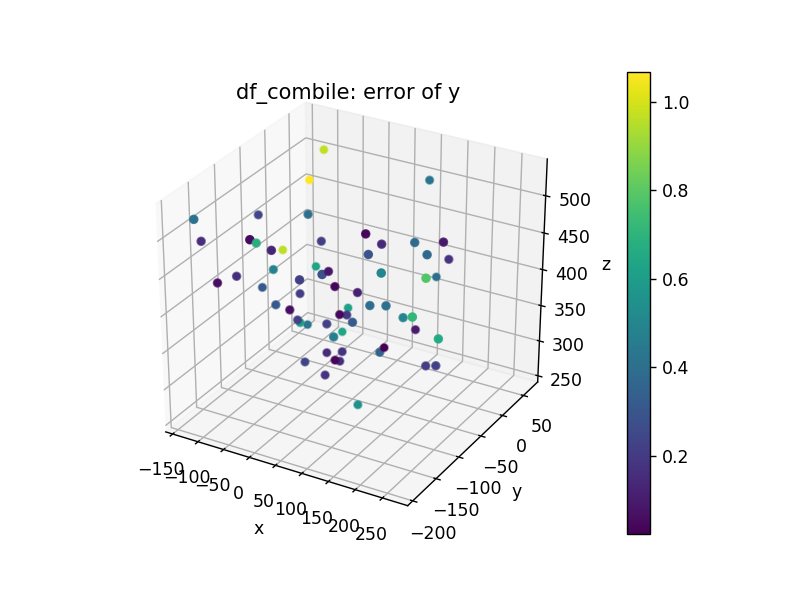

<IPython.core.display.Javascript object>


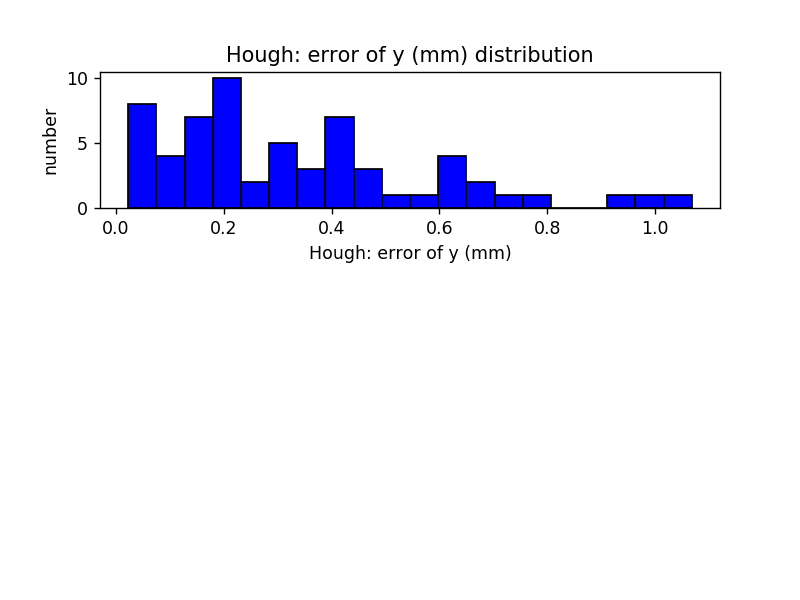

<IPython.core.display.Javascript object>


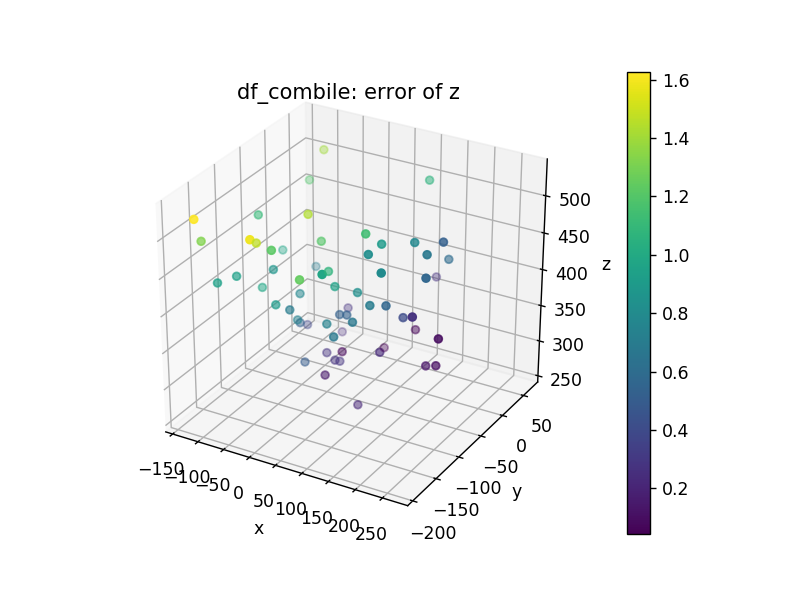

<IPython.core.display.Javascript object>


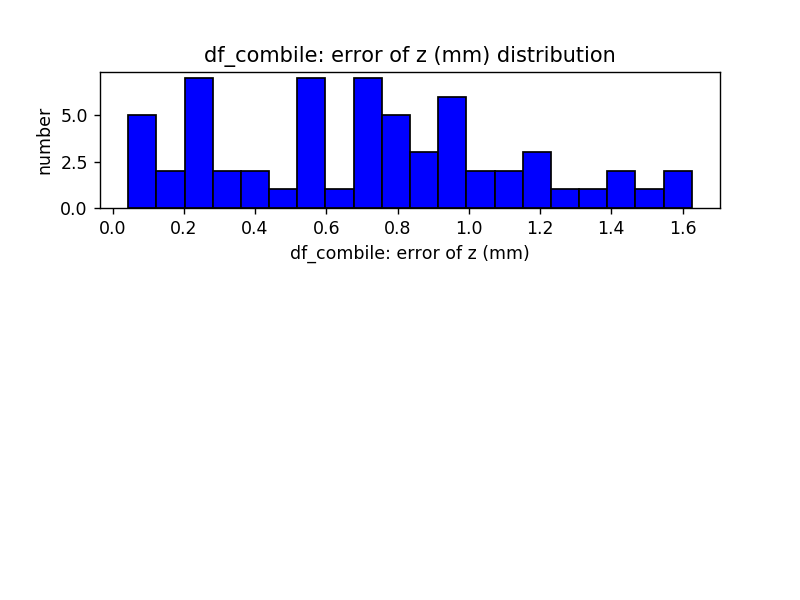

<IPython.core.display.Javascript object>


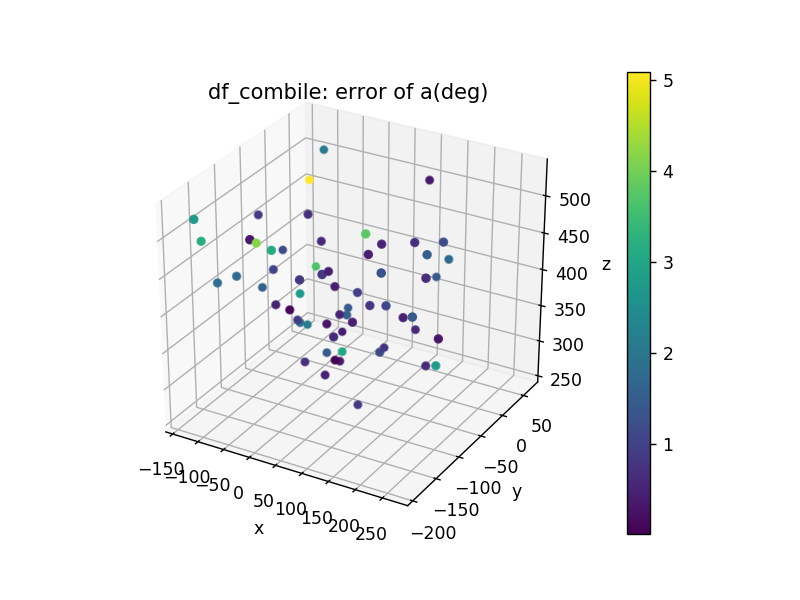

<IPython.core.display.Javascript object>


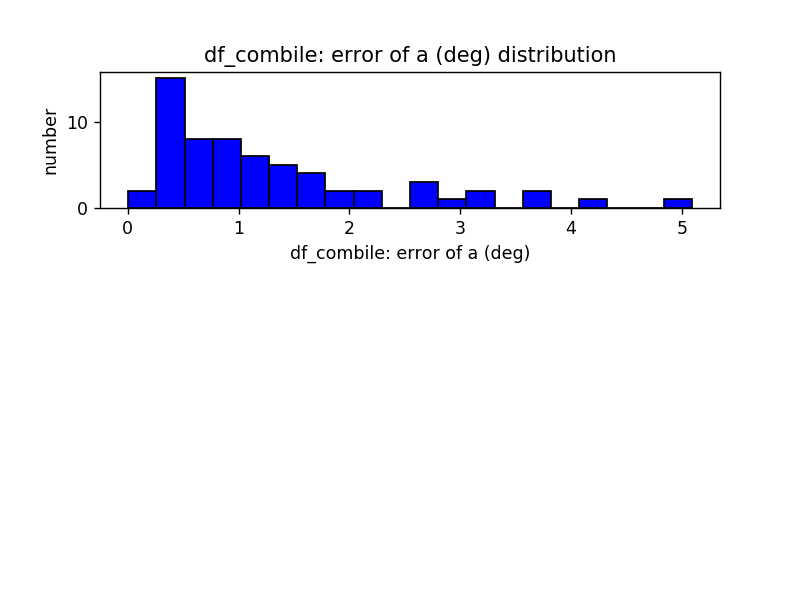

<IPython.core.display.Javascript object>


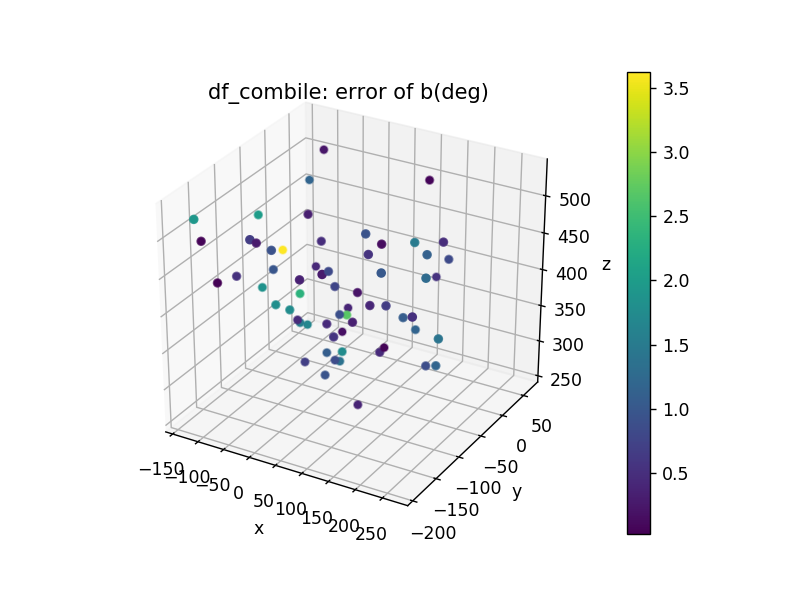

<IPython.core.display.Javascript object>


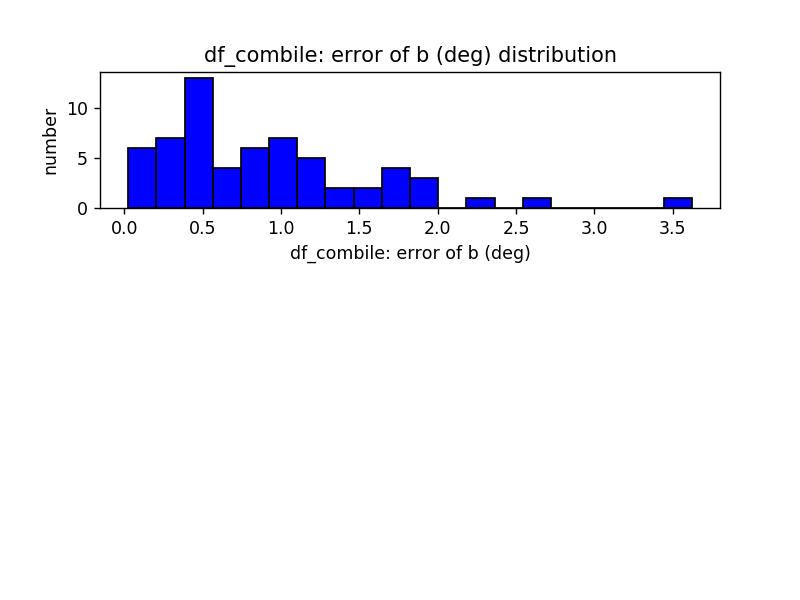

<IPython.core.display.Javascript object>


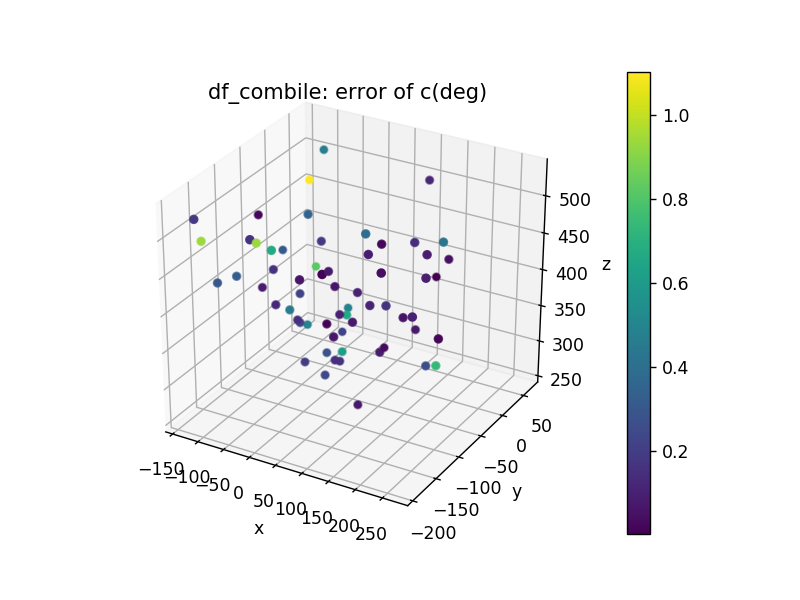

<IPython.core.display.Javascript object>


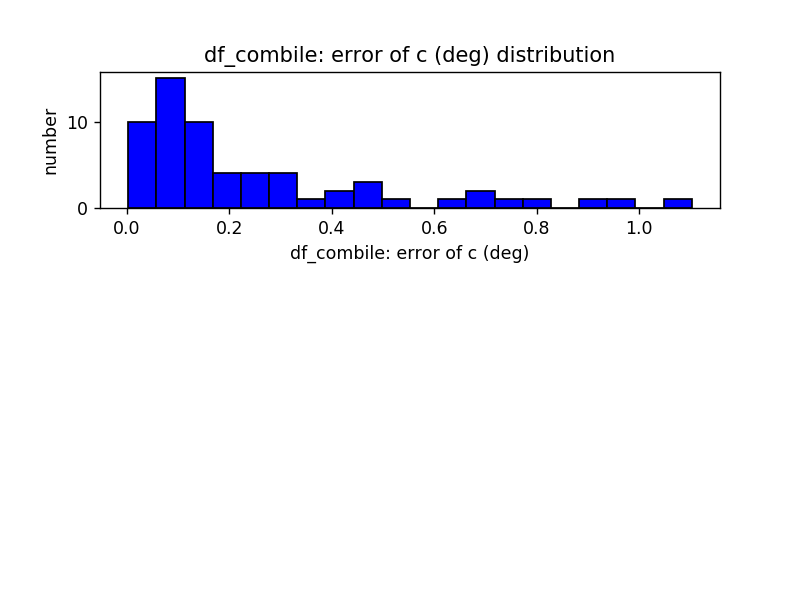

In [71]:

df_combile = data_analysor.computeErrorInBase(data_analysor.df_combile)
visualize(df_combile, "df_combile")


<IPython.core.display.Javascript object>


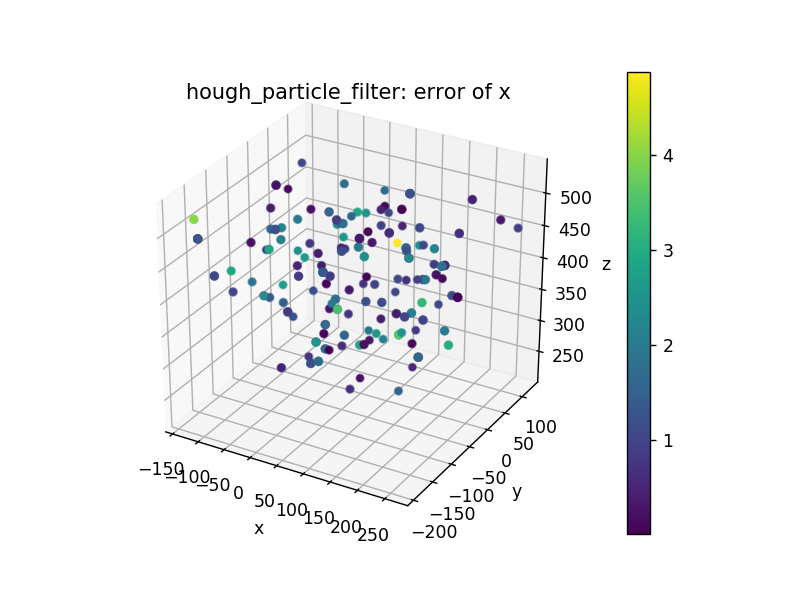

<IPython.core.display.Javascript object>


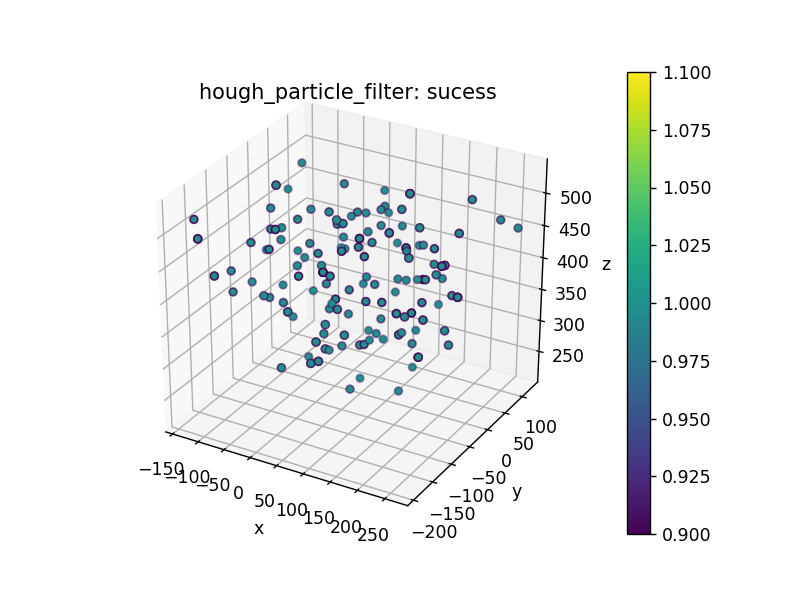

success ratio:  1.0


<IPython.core.display.Javascript object>


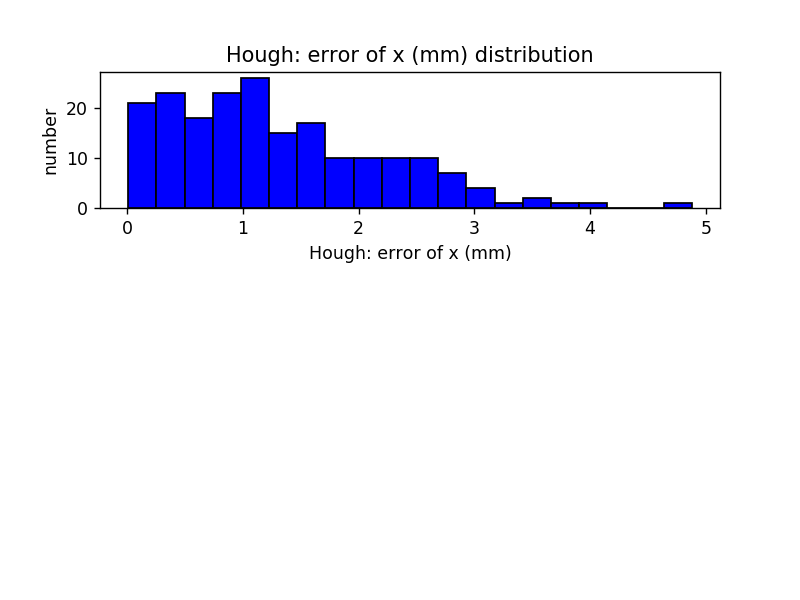

<IPython.core.display.Javascript object>


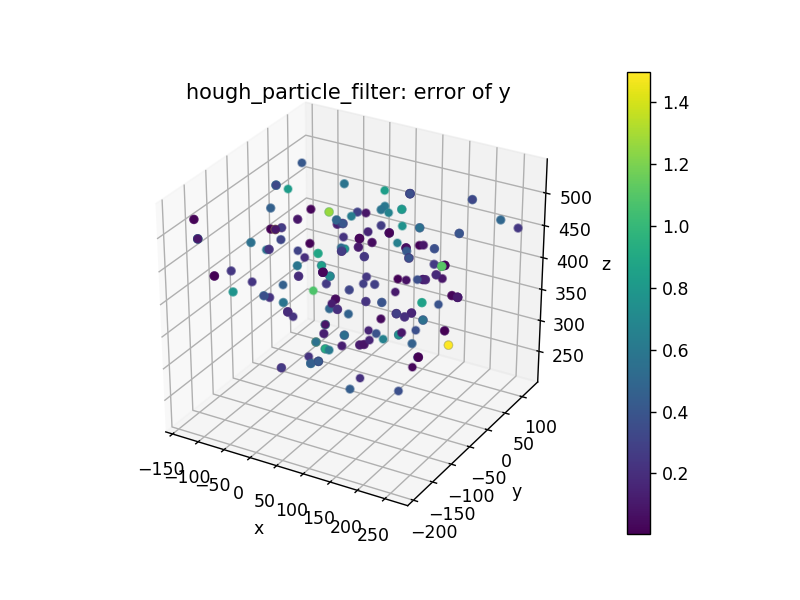

<IPython.core.display.Javascript object>


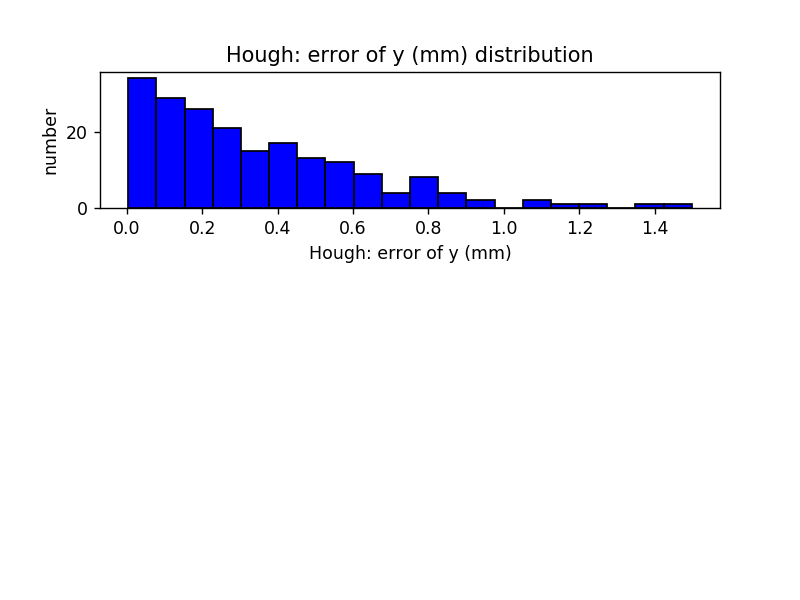

<IPython.core.display.Javascript object>


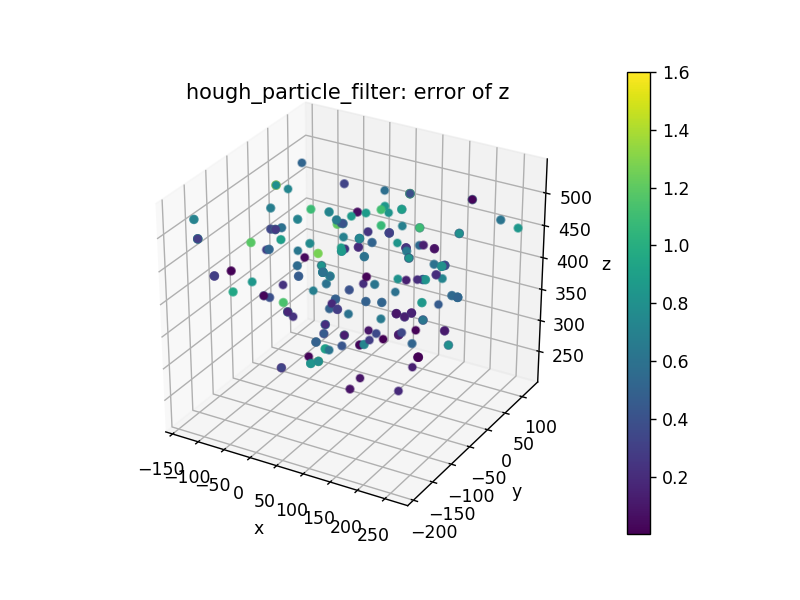

<IPython.core.display.Javascript object>


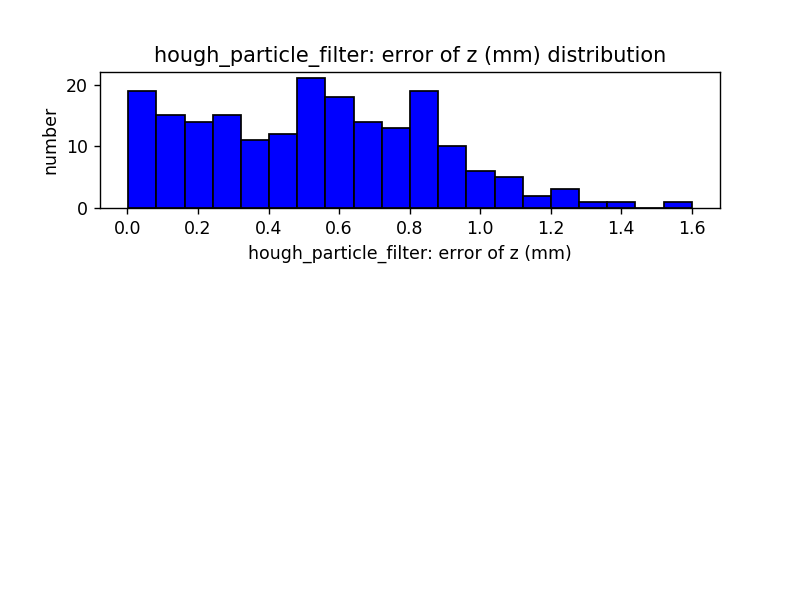

<IPython.core.display.Javascript object>


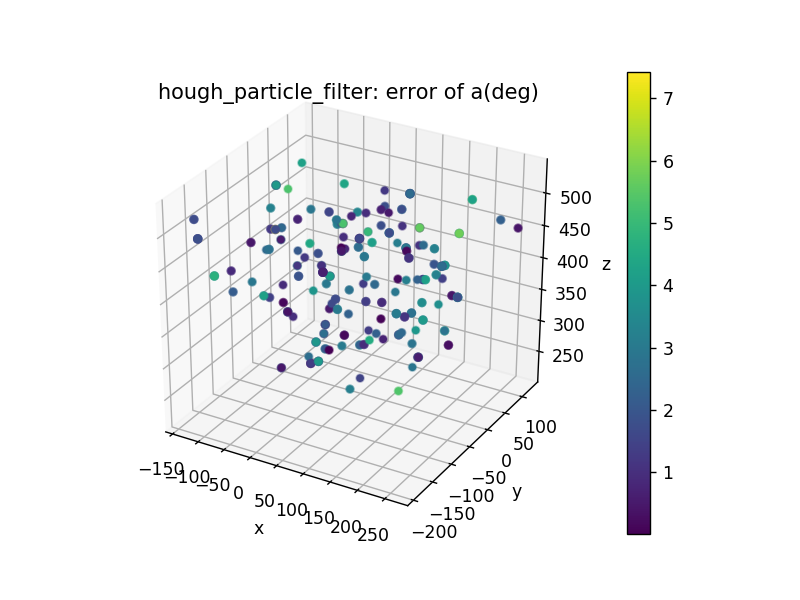

<IPython.core.display.Javascript object>


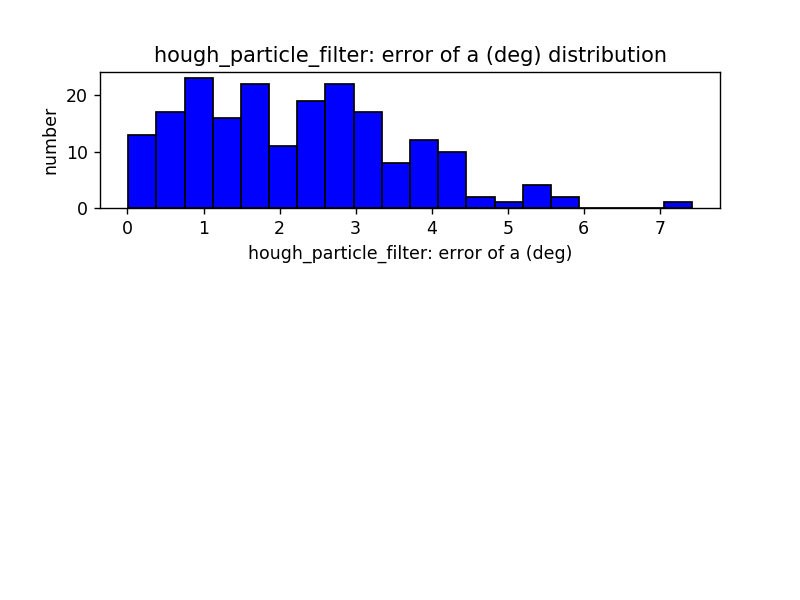

<IPython.core.display.Javascript object>


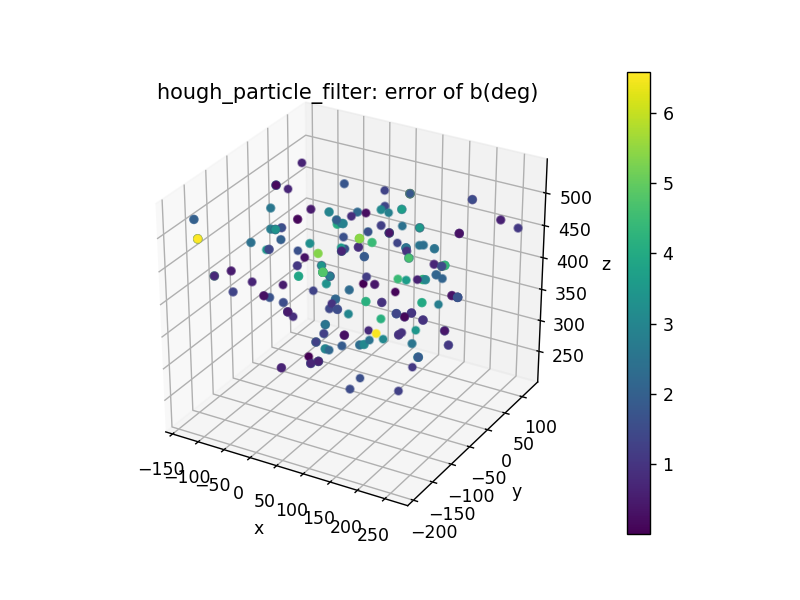

<IPython.core.display.Javascript object>


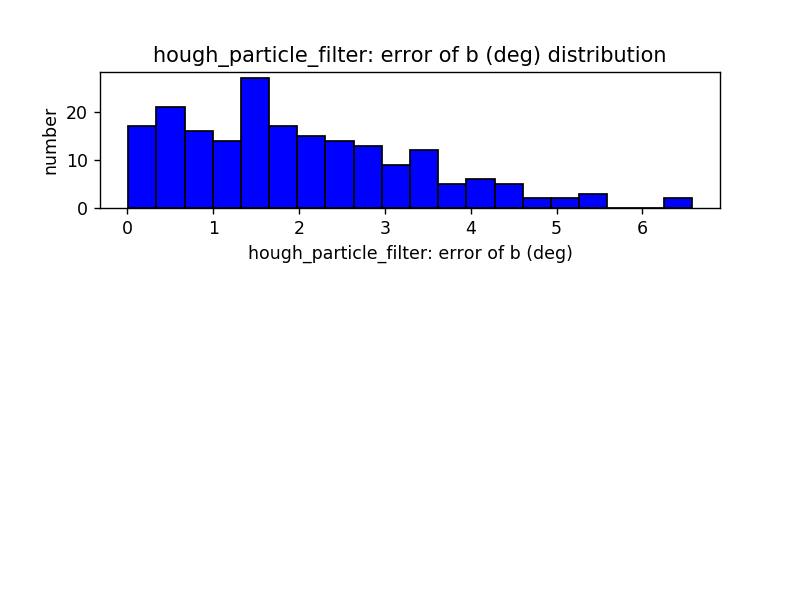

<IPython.core.display.Javascript object>


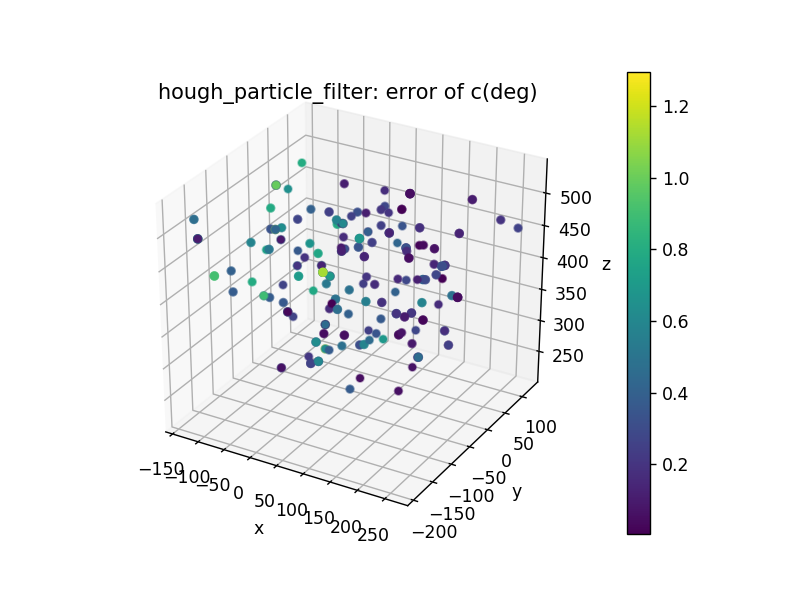

<IPython.core.display.Javascript object>


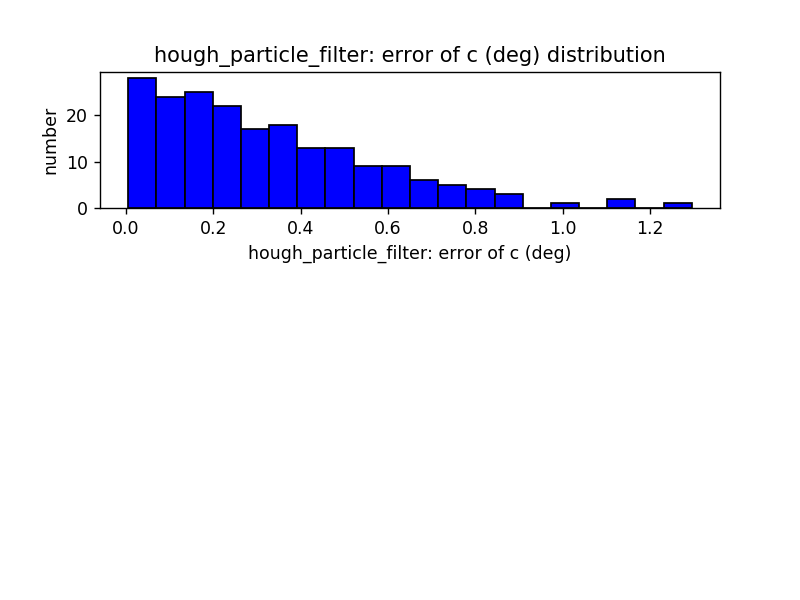

In [72]:

df_hough_particle_filter = data_analysor.computeErrorInBase(data_analysor.df_hough_particle_filter)
visualize(df_hough_particle_filter, "hough_particle_filter")